## Basic Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import glob
import random
import json
%matplotlib inline

from PIL import Image
import io

import cv2

import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder

import torchvision
from torchvision.datasets import MNIST, CIFAR10

from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torchvision.models import resnet18, ResNet18_Weights

import torchmetrics

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger

from datasets import load_dataset

from typing import Callable, Optional, List, Dict

from transformers import DonutProcessor, VisionEncoderDecoderModel

import evaluate

# Configure device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("No GPU available, using CPU")

## Load CORD-v2 Dataset

In [ ]:
# Load CORD-v2 dataset
print("Loading CORD-v2 dataset from Hugging Face:")
ds = load_dataset("naver-clova-ix/cord-v2")

print("Dataset loaded successfully!")
print("Dataset structure:")
print(ds)

# Show dataset splits
print("Available splits:")
for split in ds.keys():
    print(f"    - {split}: {len(ds[split])} samples")

## Custom Transform Classes

Define preprocessing transforms used in the training pipeline.

In [ ]:
class CLAHETransform:
    """Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)."""
    
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
    
    def __call__(self, img):
        """
        Args:
            img: PIL Image
        Returns:
            PIL Image after CLAHE
        """
        img_np = np.array(img)
        
        if len(img_np.shape) == 3:
            gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        else:
            gray = img_np
        
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        clahe_img = clahe.apply(gray)
        
        if len(img_np.shape) == 3:
            clahe_img = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2RGB)
        
        return Image.fromarray(clahe_img)


class SharpenTransform:
    """Apply sharpening filter to enhance text edges."""
    
    def __init__(self, amount=1.0):
        self.amount = amount
    
    def __call__(self, img):
        """
        Args:
            img: PIL Image
        Returns:
            PIL Image after sharpening
        """
        img_np = np.array(img)
        
        kernel = np.array([
            [0, -1, 0],
            [-1, 5, -1],
            [0, -1, 0]
        ]) * self.amount
        
        if len(img_np.shape) == 3:
            sharpened = cv2.filter2D(img_np, -1, kernel)
        else:
            sharpened = cv2.filter2D(img_np, -1, kernel)
        
        return Image.fromarray(sharpened)


# Initialize transform instances
clahe_transform = CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8))
sharpen_transform = SharpenTransform(amount=1.0)

print("Custom transforms defined successfully")

## Helper Functions for Donut

Utility functions for processing ground truth annotations and generating structured text sequences.

In [ ]:
def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert JSON object to a token sequence for Donut.
    
    This function recursively traverses the JSON structure and converts it into a special
    token format that Donut can process. Each key-value pair is wrapped in special tokens
    that indicate the hierarchical structure.
    
    Args:
        obj: JSON object (dict, list, or primitive)
        update_special_tokens_for_json_key: Whether to wrap keys in special tokens
        sort_json_key: Whether to sort dictionary keys alphabetically
    
    Returns:
        str: Token sequence representation of the JSON
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    output += (
                        fr"<s_{k}>" + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key) + fr"</s_{k}>"
                    )
                else:
                    output += json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        obj = str(obj)
        if f"<{obj}>" in processor.tokenizer.all_special_tokens:
            obj = fr"\{obj}"  # escape special tokens
        return obj


def preprocess_documents_for_donut(sample):
    """
    Preprocess a single sample for Donut training.
    
    This function prepares the image and ground truth JSON for Donut by:
    1. Converting the image to RGB
    2. Processing the image through the Donut processor
    3. Converting the ground truth JSON to token sequence
    4. Creating decoder input and labels
    
    Args:
        sample: Dictionary containing 'image' and 'ground_truth' keys
    
    Returns:
        dict: Processed sample with pixel_values, labels, and target_sequence
    """
    # Convert image to RGB
    image = sample['image'].convert('RGB')
    
    # Process image
    pixel_values = processor(image, return_tensors="pt").pixel_values
    
    # Process ground truth
    task_prompt = "<s_cord-v2>"
    ground_truth = sample['ground_truth']
    target_sequence = task_prompt + json2token(ground_truth) + processor.tokenizer.eos_token
    
    # Tokenize
    input_ids = processor.tokenizer(
        target_sequence,
        add_special_tokens=False,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )["input_ids"].squeeze(0)
    
    return {
        "pixel_values": pixel_values.squeeze(),
        "labels": input_ids,
        "target_sequence": target_sequence
    }


print("Donut helper functions defined successfully")

# Donut: Document Understanding Transformer for Structured Receipt Information Extraction
---
Donut (Document Understanding Transformer) is a vision-language model that specialized in extracting structured JSON outputs containing key-value pairs, which makes it good for parsing receipts into organized data formats. It direclty converts documents images into structured text, eliminating any kind of errors that might occur during the pipeline process on other systems. Extracting structured information from receipts is very challenging because they can have different layouts with different store formats and receipt designs, as well as other information, such as sotre details, iterm with prices, subtotals, and totals. Also, the model to extract the text needs to understand semantic differences that distinguishes between similar numbers, like item price vs total, missing fields, formatting variations, and more. Because of all this, using Donut is beneficial, since:
- It is pre-trained on large-scale documents, which gives the ability to understand document structure from millions of images.
- Generated structured JSON output directly, which is perfect for dtatabase storage and downstream applications.
- It contains multi-modal undrstanding that combines visual layout and text semantics.
- We can apply transfer learning to leverage knowledge from divese document types.

Donut follows an encoder-decoder architecture where:

1. **Encoder: Swin Transformer**:
    - **Input**: Receipt an RGB image and resized to fixed dimensions.
    - **Process**: The image is divided into patches using hierarchical windows, creating multi-scale feature representations
    - **Output**: Sequence of visual embeddings representing document structure and content
    - **Pre-trained on**: ImageNet-22K and document images
    - **What it does**: It extracts visual features, while preserving spatial relationships and hierarchical document structure
2. **Decoder: mBART (Multilingual BART)**:
    - **Input**: Visual embeddings from encoder and task prompt `<s_cord-v2>`
    - **Process**: Generates JSON tokens autoregressively (one character at a time)
    - **Output**: Structured JSON string containing receipt information
    - **Pre-trained on**: Large multilingual text corpora
    - **What it does**: Converts visual features into structured JSON using sequence-to-sequence generation. It is very robust to receipt variations, such as different layouts, fonts, and quality.
    - It uses mBART since it has a strong multilingual capabilities and can handle various receipt languages, robust JSON generation trained on structured text formats, and contextual understanding to maintain valid JSON structure throughout generation. It also gives a high accuracy on structured information extraction
3. **Cross-Attention Mechanism**: the decoder attends to encoder outputs at each generation step, and applying fine-tuning allows us to: 
    - Focus on specific document regions when generating each JSON key-value pair
    - Align visual features with semantic labels. An alternative is to use `naver-clova-ix/donut-base-finetuned-cord-v2`, which is already fine-tuned on CORD-v2, but we want to compare our custom fine-tuning strategies.
    - Handle variable document layouts and field positions

In the following steps, we are going to implement three fine-tuning strategies to adapt the pre-trained Donut model to receipt parsing:
1. **Strategy 1: Frozen Encoder (Feature Extraction)**:
    - **Freeze**: All encoder layers (Swin Transformer)
    - **Train**: Only decoder layers (mBART)
    - **Reason**: The encoder already knows how to extract visual features from documents, since it is pre-trained on document images. We only need to adapt the decoder to receipt-specific JSON structure and vocabulary.
    - **Advantages**: Fast training, low memory usage, less chance of overfitting
    - **Disadvantages**: Limited adaptation to receipt-specific visual patterns, such as thermal printing artifacts and variable quality.
    - **Best for**: Small datasets and limited compute resources (Our dataset has 1000 receipts).

2. **Strategy 2: Partial Unfreezing (Progressive Fine-Tuning)**:
    - **Freeze**: First N-2 encoder layers
    - **Train**: Last 2 encoder layers, as well as all decoder layers
    - **Reason**: Lower Swin Transformer layers learn generic features, like edges and windows, while higher layers learn task-specific patterns. By unfreezing the last 2 layers, we allow the model to adapt to receipt-specific visual characteristics like tables and text regions.
    - **Advantages**: Better domain adaptation than frozen encoder
    - **Disadvantages**: Requires more memory and compute than Strategy 1
    - **Best for**: Medium-sized datasets with some computational budget

3. **Strategy 3: Full Fine-Tuning (End-to-End Training)**:
    - **Freeze**: Nothing
    - **Train**: All encoder and decoder layers
    - **Reason**: Maximum adaptation to receipts. The model can learn receipt-specific visual features and JSON generation patterns simultaneously.
    - **Advantages**: Best performance potential, due to full customization
    - **Disadvantages**: Requires large dataset, high memory/compute, but has risk of overfitting
    - **Best for**: Large datasets and sufficient compute

## Donut Dataset Preparation

As we mentioned before, Donut is trained to perform structured information extraction from document images.
- **Input**: Receipt image (PIL Image)
- **Output**: Structured JSON string (key-value pairs representing receipt fields)
- **Error handling**: If JSON parsing fails, return empty JSON object to prevent training crashes.

**CORD-v2 Dataset Structure**:

The CORD-v2 dataset provides:
- **Images**: Receipt images in PNG format
- **Ground truth**: JSON annotations with:
  - `valid_line`: List of text lines in the receipt
  - `words`: Individual words with bounding boxes and text content
  - `category`: Semantic labels (menu.nm, menu.price, total.total_price, etc.)

**Data Extraction Process**:

We need to convert the structured JSON annotations into a format suitable for Donut's sequence-to-sequence generation. To achieve this, we will follow these steps:
1. **Parse JSON**: Load the `ground_truth` string and parse it as JSON
2. **Extract structured fields**: Iterate through `valid_line` and `words` to collect all text
3. **Create JSON output**: Package extracted information as a JSON string with key-value pairs
4. **Add task prompt**: Prepend `<s_cord-v2>` token to guide the decoder
5. **Example**:
   - Input JSON: `{"valid_line": [{"words": [{"text": "TOTAL"}, {"text": "$45.99"}]}]}`
   - Output sequence: `<s_cord-v2>{"text": "TOTAL $45.99"}</s>`

**Preprocessing Pipeline**:

For each image, we will:
1. Apply minimal ColorJitter for subtle augmentation to avoid aggressive transforms that hurt OCR.
2. Use Donut processor to handle resizing, normalization, and conversion to tensors internally.
3. Apply tokenization to convert JSON strings into token IDs using mBART tokenizer.
4. Apply padding or truncation of sequences to a `max_length` of 512 tokens.

Some special cases include:
- **Task prompt**: `<s_cord-v2>` is added as a special token to signal receipt parsing task
- **Padding tokens**: Replaced with `-100` in labels so they're ignored during loss computation
- **Max length**: Set to 512 tokens to accommodate structured JSON while fitting in GPU memory

The following class is created to combine CORD's structured annotations and Donut's expected input and output formats.

In [ ]:
class DonutDataset(Dataset):
    """
    Dataset for Donut fine-tuning on CORD-v2.
    Extracts structured information (JSON) from receipt images.
    """
    def __init__(
        self,
        hf_dataset,
        processor,
        image_transform: Optional[Callable] = None,
        max_length: int = 512,
        task_prompt: str = "<s_cord-v2>",
    ):
        self.hf_dataset = hf_dataset
        self.processor = processor
        self.image_transform = image_transform
        self.max_length = max_length
        self.task_prompt = task_prompt
        
        # Add special tokens to processor
        self.processor.tokenizer.add_special_tokens({"additional_special_tokens": [task_prompt]})
        
        print(f"DonutDataset initialized with {len(self.hf_dataset)} samples")
    
    def __len__(self) -> int:
        return len(self.hf_dataset)
    
    def extract_structured_info(self, ground_truth_str: str) -> str:
        """
        Extract structured information from CORD ground truth.
        Returns a JSON string with key-value pairs.
        """
        try:
            gt_dict = json.loads(ground_truth_str)
            
            # Extract relevant fields from CORD dataset
            structured_data = {}
            
            if 'valid_line' in gt_dict:
                all_text = []
                for line in gt_dict['valid_line']:
                    if 'words' in line:
                        line_text = []
                        for word in line['words']:
                            if 'text' in word:
                                line_text.append(word['text'])
                        if line_text:
                            all_text.append(' '.join(line_text))
                
                structured_data['text'] = ' '.join(all_text)
            
            return json.dumps(structured_data, ensure_ascii=False)
        except:
            return json.dumps({"text": ""})
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        sample = self.hf_dataset[idx]
        
        # Get image
        image = sample['image']
        
        # Apply custom preprocessing
        if self.image_transform:
            image = self.image_transform(image)
        
        # Extract structured information
        structured_json = self.extract_structured_info(sample['ground_truth'])
        
        # Create target sequence: <s_cord-v2> + JSON + </s>
        target_sequence = f"{self.task_prompt}{structured_json}</s>"
        
        # Process image
        pixel_values = self.processor(image, return_tensors="pt").pixel_values.squeeze()
        
        # Tokenize target sequence
        labels = self.processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        ).input_ids.squeeze()
        
        # Replace padding token id with -100
        labels[labels == self.processor.tokenizer.pad_token_id] = -100
        
        return {
            "pixel_values": pixel_values,
            "labels": labels,
            "target_sequence": target_sequence,
        }

# Test Donut dataset
print("Loading Donut processor...")
donut_processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")

# Donut preprocessing: only minimal ColorJitter (like in train_donut.py)
# The Donut processor handles conversion to tensor and normalization internally
donut_preprocess = transforms.Compose([
    transforms.ColorJitter(brightness=0.05, contrast=0.05),
])

# Create test dataset
donut_test_dataset = DonutDataset(
    hf_dataset=ds['train'],
    processor=donut_processor,
    image_transform=donut_preprocess,
    max_length=512,
)

# Test sample
test_sample = donut_test_dataset[0]
print(f"Sample output:")
print(f"    - Pixel values shape: {test_sample['pixel_values'].shape}")
print(f"    - Labels shape: {test_sample['labels'].shape}")
print(f"    - Target sequence preview: {test_sample['target_sequence'][:150]}...")
print(f"Donut Dataset ready!")

## Donut Model Implementation with PyTorch Lightning

We will use PyTorch Lightning for the same reasons as TrOCR:
- **Organized code**: Separates research code from engineering code
- **Built-in features**: Automatic logging, checkpointing, early stopping, multi-GPU support
- **Reproducibility**: Handles random seeds, deterministic training
- **Less boilerplate**: No need to manually write training loops, GPU transfer logic

**Model Class Structure**: The following implementation of our `DonutLightningModel` inherits from `LightningModule` and implements:
1. Initialization (`__init__`):
    - Load pre-trained `VisionEncoderDecoderModel` (Swin + mBART) from Hugging Face
    - Load corresponding `DonutProcessor` to handle image preprocessing and tokenization.
    - Add task-specific token `<s_cord-v2>` to vocabulary and resize decoder embeddings
    - Configure generation parameters, like start token, padding, and EOS token.
    - Apply freezing strategy (freeze/unfreeze layers based on strategy)
    - Initialize metrics: token-level accuracy
2. Freezing Strategy (`_apply_freezing_strategy`):
    - Iterate through `model.encoder.parameters()` and set `requires_grad = False` to freeze
    - For partial unfreezing: Access Swin layers via `model.encoder.encoder.layers[-N:]` and unfreeze
    - Decoder is always trainable: `model.decoder.parameters()` have `requires_grad = True`
    - We freeze parameters, since those don't compute gradients, which is equivalent to faster training and less memory. Also, pre-trained weights are preserved and only task-specific layers adapt for better generalization on small datasets.
3. Forward Pass (`forward`):
    - Takes `pixel_values` (image tensors) and `labels` (JSON token IDs)
    - Returns model outputs including loss and logits
    - Loss is automatically computed by comparing logits with labels (cross-entropy)
4. Training Step (`training_step`):
    - This is what happens in each training iteration:
        1. Forward pass: `outputs = self(pixel_values, labels=labels)`
        2. Extract loss: `loss = outputs.loss`
        3. Compute token-level accuracy from logits (no generation during training for efficiency)
        4. Log metrics: `self.log('train_loss', loss)`, `self.log('train_acc', self.train_acc)`
        5. Return loss (Lightning automatically calls `loss.backward()` and optimizer step)
    - Computing accuracy from logits is much faster than generating full JSON sequences
5. Validation Step (`validation_step`):
    - Evaluate model on validation set to monitor overfitting
        1. Forward pass, same as training.
        2. Compute token-level accuracy from logits
        3. Log metrics: `self.log('val_loss', loss)`, `self.log('val_acc', self.val_acc)`
    - No JSON generation during validation for speed (only during test)
6. Test Step (`test_step`):
    - Generate full JSON sequences for qualitative evaluation
        1. Forward pass for loss and accuracy
        2. Generate predictions: `model.generate(pixel_values, max_length=512)`
        3. Decode predictions to JSON strings
        4. Compute token-level accuracy
        5. Log metrics and return predictions for analysis
7. Optimizer Configuration (`configure_optimizers`)
    - AdamW Optimizer:
        - Variant of Adam with decoupled weight decay to prevent overfitting
        - Learning rate: 5e-5, which is commonly used for fine-tuning document understanding models
        - Weight decay: 0.01, which is L2 regularization.
    - Cosine Annealing with Warmup:
        - Gradually increases LR during warmup (500 steps)
        - Then decreases following cosine schedule
        - Helps model converge smoothly and avoid early training instability

Some key variables are:
1. `max_length=512`: limit inference time and memory usage while accommodating structured JSON outputs. We decided on 512, since JSON outputs are typically longer than plain text.
2. We replace padding with `-100` in labels, since PyTorch's `CrossEntropyLoss` ignores index `-100`, which ensures padding tokens don't contribute to loss and prevents the model from learning to predict padding.
3. We have log metrics with `prog_bar=True` to display metrics in real-time during training, which helps us monitor training progress.
4. `<s_cord-v2>` task prompt: guides the decoder to generate receipt-specific JSON structure

This implementation follows best practices for fine-tuning vision-language models and provides a clean, maintainable codebase for experimentation with structured document understanding.

In [ ]:
from transformers import get_cosine_schedule_with_warmup

class DonutLightningModel(L.LightningModule):
    """
    Donut model with PyTorch Lightning for document understanding.
    
    Fine-tuning strategy:
    - Strategy 1: Freeze encoder, train decoder only
    - Strategy 2: Unfreeze last 2 encoder layers + decoder
    - Strategy 3: Full fine-tuning
    """
    def __init__(
        self,
        model_name: str = "naver-clova-ix/donut-base",
        learning_rate: float = 5e-5,
        warmup_steps: int = 500,
        freeze_encoder: bool = True,
        unfreeze_last_n_layers: int = 0,
        max_length: int = 512,
    ):
        super().__init__()
        self.save_hyperparameters()
        
        # Load pre-trained Donut model
        self.model = VisionEncoderDecoderModel.from_pretrained(model_name)
        self.processor = DonutProcessor.from_pretrained(model_name)
        
        # Add task-specific token
        self.processor.tokenizer.add_special_tokens({"additional_special_tokens": ["<s_cord-v2>"]})
        self.model.decoder.resize_token_embeddings(len(self.processor.tokenizer))
        
        # Apply freezing strategy
        self._apply_freezing_strategy(freeze_encoder, unfreeze_last_n_layers)
        
        # Configure generation parameters
        self.model.config.decoder_start_token_id = self.processor.tokenizer.convert_tokens_to_ids(["<s_cord-v2>"])[0]
        self.model.config.pad_token_id = self.processor.tokenizer.pad_token_id
        self.model.config.eos_token_id = self.processor.tokenizer.eos_token_id
        
        # Metrics - Token-level accuracy (multiclass with ignore_index for padding)
        vocab_size = len(self.processor.tokenizer)
        self.train_acc = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=vocab_size,
            ignore_index=-100
        )
        self.val_acc = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=vocab_size,
            ignore_index=-100
        )
        
    def _apply_freezing_strategy(self, freeze_encoder: bool, unfreeze_last_n_layers: int):
        """
        Apply layer freezing strategy
        
        Args:
            freeze_encoder: If True, freeze Swin Transformer encoder
            unfreeze_last_n_layers: Number of last encoder layers to unfreeze
        """
        if freeze_encoder:
            # Freeze all encoder parameters
            for param in self.model.encoder.parameters():
                param.requires_grad = False
            print("Encoder (Swin Transformer) frozen")
            
            # Unfreeze last N layers if specified
            if unfreeze_last_n_layers > 0:
                # Access Swin Transformer layers
                try:
                    encoder_layers = self.model.encoder.encoder.layers
                    for layer in encoder_layers[-unfreeze_last_n_layers:]:
                        for param in layer.parameters():
                            param.requires_grad = True
                    print(f"Unfroze last {unfreeze_last_n_layers} encoder layers")
                except Exception as e:
                    print(f"Could not unfreeze specific layers: {e}")
        else:
            print("Encoder unfrozen (full fine-tuning mode)")
        
        # Decoder is always trainable
        for param in self.model.decoder.parameters():
            param.requires_grad = True
        print("Decoder (mBART) trainable")
        
        # Count trainable parameters
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print(f"Trainable parameters: {trainable_params:,} / {total_params:,} "
              f"({100 * trainable_params / total_params:.2f}%)")
    
    def forward(self, pixel_values, labels=None):
        return self.model(pixel_values=pixel_values, labels=labels)
    
    def training_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        
        outputs = self(pixel_values, labels=labels)
        loss = outputs.loss
        
        # Calculate token-level accuracy
        with torch.no_grad():
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            preds_flat = preds.view(-1)
            labels_flat = labels.view(-1)
            self.train_acc(preds_flat, labels_flat)
        
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_acc', self.train_acc, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        
        outputs = self(pixel_values, labels=labels)
        loss = outputs.loss
        
        # Calculate token-level accuracy
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        preds_flat = preds.view(-1)
        labels_flat = labels.view(-1)
        self.val_acc(preds_flat, labels_flat)
        
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', self.val_acc, prog_bar=True, on_epoch=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        
        outputs = self(pixel_values, labels=labels)
        
        # Generate predictions
        generated_ids = self.model.generate(
            pixel_values,
            max_length=self.hparams.max_length,
            early_stopping=True,
            pad_token_id=self.processor.tokenizer.pad_token_id,
            eos_token_id=self.processor.tokenizer.eos_token_id,
        )
        generated_texts = self.processor.batch_decode(generated_ids, skip_special_tokens=True)
        
        # Calculate token-level accuracy
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        preds_flat = preds.view(-1)
        labels_flat = labels.view(-1)
        
        test_acc = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=len(self.processor.tokenizer),
            ignore_index=-100
        ).to(self.device)
        acc = test_acc(preds_flat, labels_flat)
        
        self.log('test_acc', acc, prog_bar=True)
        
        return {'predictions': generated_texts, 'test_acc': acc}
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            betas=(0.9, 0.999),
            eps=1e-8,
            weight_decay=0.01
        )
        
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.hparams.warmup_steps,
            num_training_steps=self.trainer.estimated_stepping_batches
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'step'
            }
        }

print("Donut Lightning Model defined successfully")

## Donut DataModule with Custom Preprocessing

Now, we will implement a `LightningDataModule` to encapsulate all data-related logic in one place, such as:
- Dataset creation (train/val/test splits)
- Data transformations and augmentations
- DataLoader configuration, like batch size, shuffling and workers.
- Reproducibility to ensure consistent data handling across experiments.

Instead of relying only on Donut processor, we use minimal custom preprocessing:
- **Minimal ColorJitter**: subtle brightness and contrast adjustments to avoid aggressive transforms that hurt OCR performance.
- Applying minimal augmentation is very important because it slightly increases dataset diversity without introducing artifacts. Then, using Donut Processor helps us resize, normalize and convert to tensor with the purpose of preparing for model input.

**Augmentation Strategy**: 
- Training step: we will apply minimal augmentations to slightly increase dataset diversity.
    - Color jitter with 0.05 brightness and contrast to simulate subtle lightning variations.
    - No rotation or geometric transforms, since these can hurt document understanding performance.
- Validation and Test sets: no augmentation, only processor normalization.
    - We want to measure true performance on clean, processed images.
    - Augmentation during validation would give misleading metrics.

**DataLoader Configuration**:
- **Batch size**: Set to 4 for frozen and partial strategies, 3 for full
- **Shuffle**: True for training for random order, but False for validation and test
- **num_workers**: Set to 4 for parallel data loading
- **pin_memory**: True for faster CPU-to-GPU transfer
- **persistent_workers**: True to reuse workers between epochs
- **collate_fn**: Custom function to properly batch mixed data types (tensors and JSON strings)


**Collate Function Explained**: The main issue is that PyTorch's default collate can't handle mixed types like tensors and list of strings. For this, we created a custom collate function that:
1. Stacks `pixel_values` tensors into batch: `torch.stack([item['pixel_values'] for item in batch])`
2. Stacks `labels` tensors into batch: `torch.stack([item['labels'] for item in batch])`
3. Keeps target_sequence as list: `[item['target_sequence'] for item in batch]` (used for debugging and analysis)

This will ensure us proper batching, while preserving JSON references for analysis and evaluation.

In [ ]:
class DonutDataModule(L.LightningDataModule):
    """DataModule for Donut training with CORD-v2 dataset."""
    
    def __init__(
        self,
        hf_dataset,
        processor,
        batch_size: int = 4,
        num_workers: int = 4,
        max_length: int = 512,
        use_augmentation: bool = True,
    ):
        super().__init__()
        self.hf_dataset = hf_dataset
        self.processor = processor
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.max_length = max_length
        self.use_augmentation = use_augmentation
        
        # Minimal augmentation for OCR - avoid rotation/sharpening that hurt performance
        if use_augmentation:
            self.train_transform = transforms.Compose([
                transforms.ColorJitter(brightness=0.05, contrast=0.05),
            ])
        else:
            self.train_transform = None
        
        self.val_transform = None
    
    def setup(self, stage: str = None):
        self.train_dataset = DonutDataset(
            hf_dataset=self.hf_dataset['train'],
            processor=self.processor,
            image_transform=self.train_transform,
            max_length=self.max_length,
        )
        
        self.val_dataset = DonutDataset(
            hf_dataset=self.hf_dataset['validation'],
            processor=self.processor,
            image_transform=self.val_transform,
            max_length=self.max_length,
        )
        
        self.test_dataset = DonutDataset(
            hf_dataset=self.hf_dataset['test'],
            processor=self.processor,
            image_transform=self.val_transform,
            max_length=self.max_length,
        )
        
        print(f"[DonutDataModule] Train: {len(self.train_dataset)}, "
              f"Val: {len(self.val_dataset)}, Test: {len(self.test_dataset)}")
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False,
            collate_fn=self.collate_fn,
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False,
            collate_fn=self.collate_fn,
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            collate_fn=self.collate_fn,
        )
    
    @staticmethod
    def collate_fn(batch):
        """
        Custom collate function to handle batching.
        
        This is necessary to properly batch mixed data types: tensors (pixel_values, labels) 
        are stacked, while text strings are kept as a list.
        """
        pixel_values = torch.stack([item['pixel_values'] for item in batch])
        labels = torch.stack([item['labels'] for item in batch])
        target_sequences = [item['target_sequence'] for item in batch]
        
        return {
            'pixel_values': pixel_values,
            'labels': labels,
            'target_sequence': target_sequences,
        }

print("Donut DataModule defined successfully")

## Donut Training Setup

We train three independent Donut models using different fine-tuning strategies to compare performance vs computational cost.

**Three Strategies**:

| Strategy | Trainable Params | Frozen Params | Epochs | Batch Size | Use Case |
|----------|-----------------|---------------|--------|------------|----------|
| **1. Frozen Encoder** | ~60M (decoder) | ~89M (encoder) | 30 | 4 | Fast experiments, limited resources |
| **2. Partial Unfreezing** | ~80M (decoder + last 2 encoder layers) | ~69M (first encoder layers) | 25 | 4 | Balanced performance/efficiency |
| **3. Full Fine-Tuning** | ~149M (all layers) | 0 | 20 | 3 | Maximum performance |

**Shared Training Configuration**:

All strategies use the same optimized hyperparameters:
- **Gradient accumulation**: 8 steps for effective batch sizes of 32/32/24
- **Learning rate**: `5e-5` with cosine annealing and 500-step warmup
- **Optimizer**: AdamW, since it's adaptive and works well with document understanding models
- **Precision**: Mixed FP16 because it's 2x faster and requires 50% less memory
- **Gradient clipping**: 1.0 to prevent instability
- **Validation**: 2× per epoch for early overfitting detection
- **Early stopping patience**: 10 epochs 

The strategies have different epochs and batch sizes because:
- **Strategy 1 (30 epochs, batch 4)**: Only train the decoder is fast and can afford more iterations with larger batches
- **Strategy 2 (25 epochs, batch 4)**: Moderate training time for balanced approach
- **Strategy 3 (20 epochs, batch 3)**: Fewer epochs to prevent overfitting on small dataset, smaller batch due to full model updates

Each strategy has detailed explanation and training configuration in the following sections.

In [ ]:
# Initialize Donut DataModule
donut_dm = DonutDataModule(
    hf_dataset=ds,
    processor=donut_processor,
    batch_size=4,
    num_workers=4,
    max_length=512,
    use_augmentation=True,
)

donut_dm.setup()

# Strategy 1: Freeze encoder completely (only train decoder)
print("Strategy 1: Freeze Encoder - Train Decoder Only")
donut_model_frozen = DonutLightningModel(
    model_name="naver-clova-ix/donut-base",
    learning_rate=5e-5,
    warmup_steps=500,
    freeze_encoder=True,
    unfreeze_last_n_layers=0,
    max_length=512,
)

# Strategy 2: Freeze encoder but unfreeze last 2 layers
print("Strategy 2: Freeze Encoder - Unfreeze Last 2 Layers")
donut_model_partial = DonutLightningModel(
    model_name="naver-clova-ix/donut-base",
    learning_rate=5e-5,
    warmup_steps=500,
    freeze_encoder=True,
    unfreeze_last_n_layers=2,
    max_length=512,
)

# Strategy 3: Full fine-tuning (unfreeze everything)
print("Strategy 3: Full Fine-Tuning (All Layers Trainable)")
donut_model_full = DonutLightningModel(
    model_name="naver-clova-ix/donut-base",
    learning_rate=5e-5,
    warmup_steps=500,
    freeze_encoder=False,
    unfreeze_last_n_layers=0,
    max_length=512,
)

print("All Donut models initialized")

## Donut Training - Strategy 1: Frozen Encoder

In this first strategy, we will freeze encoder (Swin Transformer) and train only decoder (mBART). The configuration we'll implement is:
- Epochs: 30, more iterations since it should be the fastest
- Batch size: 4, to use a machine with approximately 20GB VRAM (A4500)
- Gradient accumulation: 8, effective batch = 32 (stable gradients for JSON generation)
- Learning rate: 5e-5, with cosine annealing and 500-step warmup
- Precision FP16 mixed: it's 2 times faster and requires 50% less memory
- Gradient clipping: 1.0, prevents exploding gradients (important for sequence generation)
- Validation: 2x per epoch, early overfitting detection

**Callbacks & Logging**:
- ModelCheckpoint: 
    - Saves top 3 models by `val_loss` and last checkpoint
    - Format: `donut-frozen-{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}.ckpt`
    - Directory: `./donut_checkpoints/strategy1_frozen/`
    - Enables resuming interrupted training
- EarlyStopping:
    - Patience: 10 epochs. Stops if `val_loss` doesn't improve (longer patience for structured generation)
    - Prevents overfitting and saves compute time
- CSVLogger:
    - Saves all metrics (epoch, train_loss, val_loss, train_acc, val_acc)
    - Directory: `./donut_logs/strategy1_frozen/metrics.csv`

Additionally, we use gradient accumulation because the batch size of 32 won't fit even with 20GB VRAM, so the solution is to process 4 samples × 8 times, and then updating the weights. With this, we expect same gradient quality as if the batch size is 32, but using the memory of a batch size of 4.

In [ ]:
# Configure callbacks for Donut Strategy 1
donut_checkpoint_s1 = ModelCheckpoint(
    dirpath='./donut_checkpoints/strategy1_frozen',
    filename='donut-frozen-{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}',
    monitor='val_loss',
    mode='min',
    save_top_k=3,
    save_last=True,
    verbose=True,
)

donut_early_stop_s1 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    verbose=True,
)

donut_csv_logger_s1 = CSVLogger(save_dir='./donut_logs', name='strategy1_frozen')

# Initialize trainer for Donut Strategy 1
donut_trainer_s1 = L.Trainer(
    max_epochs=30,
    callbacks=[donut_checkpoint_s1, donut_early_stop_s1],
    logger=donut_csv_logger_s1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    precision='16-mixed',
    accumulate_grad_batches=8,
    gradient_clip_val=1.0,
    log_every_n_steps=10,
    val_check_interval=0.5,
    enable_progress_bar=True,
    enable_model_summary=True,
)

print("Donut Strategy 1 Trainer configured")
print(f"Checkpoints: {donut_checkpoint_s1.dirpath}")
print(f"Effective batch size: {4 * 8} (batch_size * accumulate_grad_batches)")

In [ ]:
checkpoint_path = './donut_checkpoints/strategy1_frozen/last.ckpt'
if os.path.exists(checkpoint_path):
    print(f"Resuming Donut S1 from {checkpoint_path}")
    donut_trainer_s1.fit(donut_model_frozen, donut_dm, ckpt_path=checkpoint_path)
else:
    print("Starting Donut S1 from scratch")
    donut_trainer_s1.fit(donut_model_frozen, donut_dm)

## Donut Evaluation - Strategy 1

After training, we need to evaluate the final performance on the test set, which consists of 100 receipts. For this, we'll load the best checkpoint, with the lowest `val_loss` and run on the test set to compute the metrics.

**Metrics**:
- **Validation Loss (Cross-Entropy)**: measures model confidence in JSON token generation
    - **< 0.3**: Excellent (very confident, valid JSON)
    - **0.3-0.6**: Good
    - **0.6-1.0**: Fair
    - **> 1.0**: Poor (likely generates invalid JSON)
- **Token-Level Accuracy**: percentage of correctly predicted JSON tokens:
    - Example:
        ```
        Ground truth: ["{", "\"", "text", "\"", ":", " ", "\"", "TOTAL"] (8 tokens)
        Prediction:   ["{", "\"", "text", "\"", ":", " ", "\"", "TOTAL"] (8 correct)
        Accuracy: 8/8 = 100%
        ```
    - **≥ 0.95**: Excellent (nearly perfect JSON structure)
    - **0.90-0.95**: Good
    - **0.85-0.90**: Fair
    - **< 0.85**: Poor (malformed JSON likely)

The expected results of this strategy, based on CORD-v2 benchmarks, are:
- **Val loss**: 0.2-0.5
- **Token accuracy**: 90-94%
- **Training time**: 6-8 hours (with early stopping)
- **JSON validity**: High (most outputs should be valid JSON)

In [ ]:
best_model_path = donut_checkpoint_s1.best_model_path
print(f"Evaluating Donut S1: {best_model_path}")
donut_trainer_s1.test(donut_model_frozen, donut_dm, ckpt_path=best_model_path)

In [ ]:
best_checkpoint_d1 = donut_checkpoint_s1.best_model_path
donut_model_s1_loaded = DonutLightningModel.load_from_checkpoint(best_checkpoint_d1)
donut_model_s1_loaded.eval()

test_dataloader = donut_dm.test_dataloader()
test_batch = next(iter(test_dataloader))

with torch.no_grad():
    pixel_values = test_batch['pixel_values']
    generated_ids = donut_model_s1_loaded.model.generate(
        pixel_values, 
        max_length=768,
        early_stopping=True,
        pad_token_id=donut_model_s1_loaded.processor.tokenizer.pad_token_id,
        eos_token_id=donut_model_s1_loaded.processor.tokenizer.eos_token_id,
    )
    predictions = donut_model_s1_loaded.processor.batch_decode(generated_ids, skip_special_tokens=True)
    target_sequences = test_batch['target_sequence']

num_samples = min(3, len(predictions))
for i in range(num_samples):
    print(f"Sample {i+1}:")
    print(f"Prediction: {predictions[i]}")
    print(f"Ground Truth: {target_sequences[i]}")

## Donut Training - Strategy 2: Partial Unfreezing

Now, we'll implement the second strategy for Donut model. Here, we'll unfreeze the last 2 Swin Transformer layers, while keeping the rest frozen. This allows the model to adapt higher-level visual features to receipt-specific document patterns, such as table structures, receipt headers, itemized lists, and price alignments, while preserving the low-level feature extraction learned from pre-training.

**Changes compared to Strategy 1**:
- **Trainable parameters**: ~80M (decoder + last 2 Swin layers)
- **Frozen parameters**: ~69M (first Swin layers)
- **Epochs**: 25, 5 fewer epochs since it should take longer per epoch
- **Batch size**: 4, same as Strategy 1
- **Training time**: approximately 7-9 hours because it's slower than Strategy 1 due to more layers to train

We chose this approach because:
- The lower Swin Transformer layers learn generic visual features like edges, patches, and basic textures, that's why we keep them frozen.
- The higher Swin layers learn document-specific hierarchical patterns, that's why we unfreeze to adapt the model for receipt structure understanding.
- Balances domain adaptation with training efficiency.

The rest of the configuration remains the same, in terms of gradient accumulation (8 steps for effective batch 32), learning rate (5e-5), precision (FP16), callbacks (ModelCheckpoint, EarlyStopping, CSVLogger).

The expected results of this strategy, based on CORD-v2 benchmarks, are:
- **Val loss**: 0.15-0.4, which is lower than Strategy 1
- **Token accuracy**: 92-96%, which is better than Strategy 1
- **Training time**: 7-9 hours with early stopping
- **JSON quality**: Better structure understanding, fewer field extraction errors

In [ ]:
# Configure callbacks for Donut Strategy 2
donut_checkpoint_s2 = ModelCheckpoint(
    dirpath='./donut_checkpoints/strategy2_partial',
    filename='donut-partial-{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}',
    monitor='val_loss',
    mode='min',
    save_top_k=3,
    save_last=True,
    verbose=True,
)

donut_early_stop_s2 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    verbose=True,
)

donut_csv_logger_s2 = CSVLogger(save_dir='./donut_logs', name='strategy2_partial')

# Initialize trainer for Donut Strategy 2
donut_trainer_s2 = L.Trainer(
    max_epochs=25,
    callbacks=[donut_checkpoint_s2, donut_early_stop_s2],
    logger=donut_csv_logger_s2,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    precision='16-mixed',
    accumulate_grad_batches=8,
    gradient_clip_val=1.0,
    log_every_n_steps=10,
    val_check_interval=0.5,
    enable_progress_bar=True,
    enable_model_summary=True,
)

print("Donut Strategy 2 Trainer configured")
print(f"Checkpoints: {donut_checkpoint_s2.dirpath}")
print(f"Effective batch size: {4 * 8} (batch_size * accumulate_grad_batches)")

In [ ]:
checkpoint_path = './donut_checkpoints/strategy2_partial/last.ckpt'
if os.path.exists(checkpoint_path):
    print(f"Resuming Donut S2 from {checkpoint_path}")
    donut_trainer_s2.fit(donut_model_partial, donut_dm, ckpt_path=checkpoint_path)
else:
    print("Starting Donut S2 from scratch")
    donut_trainer_s2.fit(donut_model_partial, donut_dm)

## Donut Evaluation - Strategy 2

Same as before, after training Strategy 2, we load the best checkpoint and compute metrics on the 100-receipt test set to compare the performance against the first strategy. We expect better accuracy, since the model is adapting to visual features of receipt-specific document structure.

- We expect a lower validation loss, due to better calibrated predictions (around 0.15-0.4)
- Improved JSON structure quality with fewer missing or incorrect fields.
- Higher token accuracy, around 92-96%.
- Better handling of receipt-specific layout patterns like itemized lists, tables, and field alignments.

In [ ]:
best_model_path = donut_checkpoint_s2.best_model_path
print(f"Evaluating Donut S2: {best_model_path}")
donut_trainer_s2.test(donut_model_partial, donut_dm, ckpt_path=best_model_path)

## Donut Training - Strategy 3: Full Fine-tuning

For the last strategy we'll implement for Donut, we are going to unfreeze all layers, encoder and decoder. This will provide maximum adaptation to the receipt domain, but requires careful training to avoid overfitting on our small dataset of 800 receipts. The following is what changed, compared to the other models:

- **Trainable parameters**: ~149M, which is equivalent to all layers
- **Frozen parameters**: 0
- **Epochs**: 20, fewer epochs to prevent overfitting.
- **Batch size**: 3, reduced due to memory constraints (all layers update)
- **Training time**: slowest since all parameters update.

As for the batch size, gradient accumulation (8 steps for effective batch 24), learning rate (5e-5), callbacks, and other configuration parameters, they all remain the same as the previous strategies. We expect the following results:

- **Val loss**: 0.1-0.35, which would be the best of all strategies if there's no overfitting.
- **Token accuracy**: 94-97%, which is the highest accuracy
- **Training time**: 8-11 hours with early stopping
- **JSON quality**: Best field extraction and structure understanding if overfitting is avoided

The trade-offs of using this strategy are:
- Potentially the best performance, since the model can fully adapt to receipt document understanding
- It learns receipt-specific characteristics at both low-level (edges, patches) and high-level (document structure) visual patterns
- It is slower in training because all layers compute gradients and update weights
- Has some risk of overfitting, due to the small dataset and the large model

In [ ]:
# Update DataModule for Strategy 3 with smaller batch size
donut_dm_s3 = DonutDataModule(
    hf_dataset=ds,
    processor=donut_processor,
    batch_size=3,  # Reduced for full fine-tuning
    num_workers=4,
    max_length=512,
    use_augmentation=True,
)

donut_dm_s3.setup()

# Configure callbacks for Donut Strategy 3
donut_checkpoint_s3 = ModelCheckpoint(
    dirpath='./donut_checkpoints/strategy3_full',
    filename='donut-full-{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}',
    monitor='val_loss',
    mode='min',
    save_top_k=3,
    save_last=True,
    verbose=True,
)

donut_early_stop_s3 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    verbose=True,
)

donut_csv_logger_s3 = CSVLogger(save_dir='./donut_logs', name='strategy3_full')

# Initialize trainer for Donut Strategy 3
donut_trainer_s3 = L.Trainer(
    max_epochs=20,
    callbacks=[donut_checkpoint_s3, donut_early_stop_s3],
    logger=donut_csv_logger_s3,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    precision='16-mixed',
    accumulate_grad_batches=8,
    gradient_clip_val=1.0,
    log_every_n_steps=10,
    val_check_interval=0.5,
    enable_progress_bar=True,
    enable_model_summary=True,
)

print("Donut Strategy 3 Trainer configured")
print(f"Checkpoints: {donut_checkpoint_s3.dirpath}")
print(f"Effective batch size: {3 * 8} (batch_size * accumulate_grad_batches)")

In [ ]:
checkpoint_path = './donut_checkpoints/strategy3_full/last.ckpt'
if os.path.exists(checkpoint_path):
    print(f"Resuming Donut S3 from {checkpoint_path}")
    donut_trainer_s3.fit(donut_model_full, donut_dm_s3, ckpt_path=checkpoint_path)
else:
    print("Starting Donut S3 from scratch")
    donut_trainer_s3.fit(donut_model_full, donut_dm_s3)

## Donut Evaluation - Strategy 3

The evaluation process is the same. First, we load the best checkpoint and compute metrics on the 100-receipt test set, and then the results will guide our final recommendation when we compare against the best TrOCR model.

Same as before, after training Strategy 3, we'll evaluate it on the test set to determine if full fine-tuning provides better performance or if the model overfits on the 800 receipts it got during training.

- In the best case, we expect a val loss of approximately 0.1-0.35, token accuracy of 94%-97%.
- We'll also examine JSON validity rate and field extraction accuracy.
- If it overfits, the performance should be similar or worse than Strategy 2, since the model memorized training data.

In [ ]:
## Donut Evaluation - Strategy 3
best_model_path = donut_checkpoint_s3.best_model_path
print(f"Evaluating Donut S3: {best_model_path}")
donut_trainer_s3.test(donut_model_full, donut_dm_s3, ckpt_path=best_model_path)

In [ ]:
try:
    logs_d1 = pd.read_csv('./donut_logs/strategy1_frozen/version_0/metrics.csv')
    logs_d2 = pd.read_csv('./donut_logs/strategy2_partial/version_0/metrics.csv')
    logs_d3 = pd.read_csv('./donut_logs/strategy3_full/version_0/metrics.csv')
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    ax.plot(logs_d1['epoch'], logs_d1['val_loss'], label='Strategy 1: Frozen', marker='o', linewidth=2)
    ax.plot(logs_d2['epoch'], logs_d2['val_loss'], label='Strategy 2: Partial', marker='s', linewidth=2)
    ax.plot(logs_d3['epoch'], logs_d3['val_loss'], label='Strategy 3: Full', marker='^', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Validation Loss', fontsize=12)
    ax.set_title('Donut: Validation Loss Comparison Across Strategies', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Donut Strategy Comparison - Final Metrics")
    print(f"Strategy 1 (Frozen) - Best Val Loss: {logs_d1['val_loss'].min():.4f}")
    print(f"Strategy 2 (Partial)    - Best Val Loss: {logs_d2['val_loss'].min():.4f}")
    print(f"Strategy 3 (Full)   - Best Val Loss: {logs_d3['val_loss'].min():.4f}")
    
    best_losses = {
        'Strategy 1 (Frozen)': logs_d1['val_loss'].min(),
        'Strategy 2 (Partial)': logs_d2['val_loss'].min(),
        'Strategy 3 (Full)': logs_d3['val_loss'].min()
    }
    best_strategy = min(best_losses, key=best_losses.get)
    print(f"Best Strategy: {best_strategy} with Val Loss = {best_losses[best_strategy]:.4f}")
    
except FileNotFoundError:
    print("Training logs not found. Please train the models first.")

---

## Análisis de Métricas de Entrenamiento

Esta sección lee y compara los resultados de las tres estrategias de entrenamiento.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from pathlib import Path

# Función para encontrar el último archivo de métricas de cada estrategia
def find_latest_metrics(strategy_name):
    """Busca el archivo metrics.csv más reciente para una estrategia."""
    # Mapeo de estrategias a números
    strategy_numbers = {'frozen': '1', 'partial': '2', 'full': '3'}
    strategy_num = strategy_numbers.get(strategy_name, '')
    
    # Probar diferentes ubicaciones y patrones
    search_patterns = [
        f"./training/donut/donut_logs/strategy_{strategy_name}/version_*/metrics.csv",
        f"./training/donut/donut_logs/strategy{strategy_num}_{strategy_name}/version_*/metrics.csv",
        f"./donut_logs/strategy_{strategy_name}/version_*/metrics.csv",
        f"./donut_logs/strategy{strategy_num}_{strategy_name}/version_*/metrics.csv",
    ]
    
    files = []
    for pattern in search_patterns:
        files = glob.glob(pattern)
        if files:
            break
    
    if not files:
        print(f"⚠️  No se encontraron métricas para estrategia: {strategy_name}")
        print(f"   Intentó buscar en:")
        for pattern in search_patterns:
            print(f"      - {pattern}")
        return None
    
    # Ordenar por fecha de modificación y tomar el más reciente
    latest_file = max(files, key=lambda x: Path(x).stat().st_mtime)
    print(f"✅ {strategy_name}: {latest_file}")
    return latest_file

# Buscar archivos de métricas
print("🔍 Buscando archivos de métricas...\n")
strategies_to_check = ['frozen', 'partial', 'full']
metrics_files = {}

for strategy in strategies_to_check:
    filepath = find_latest_metrics(strategy)
    if filepath:
        metrics_files[strategy] = filepath

print()  # Línea en blanco para separar

# Cargar datos
metrics_data = {}
for strategy, filepath in metrics_files.items():
    try:
        df = pd.read_csv(filepath)
        metrics_data[strategy] = df
        print(f"📈 {strategy}: {len(df)} registros cargados")
    except Exception as e:
        print(f"❌ Error cargando {strategy}: {e}")

print(f"\n✅ Métricas cargadas para {len(metrics_data)} estrategia(s)")

if len(metrics_data) == 0:
    print("⚠️  No se encontraron datos de entrenamiento. Ejecuta los entrenamientos primero.")
else:
    strategies_found = list(metrics_data.keys())
    print(f"📊 Estrategias disponibles: {', '.join([s.capitalize() for s in strategies_found])}")

🔍 Buscando archivos de métricas...

✅ frozen: ./training/donut/donut_logs/strategy_frozen/version_0/metrics.csv
✅ partial: ./training/donut/donut_logs/strategy2_partial/version_7/metrics.csv
⚠️  No se encontraron métricas para estrategia: full
   Intentó buscar en:
      - ./training/donut/donut_logs/strategy_full/version_*/metrics.csv
      - ./training/donut/donut_logs/strategy3_full/version_*/metrics.csv
      - ./donut_logs/strategy_full/version_*/metrics.csv
      - ./donut_logs/strategy3_full/version_*/metrics.csv

📈 frozen: 28 registros cargados
📈 partial: 324 registros cargados

✅ Métricas cargadas para 2 estrategia(s)
📊 Estrategias disponibles: Frozen, Partial


In [4]:
# Mostrar resumen de cada estrategia
print("\n" + "="*80)
print("📊 RESUMEN POR ESTRATEGIA")
print("="*80)

for strategy, df in metrics_data.items():
    print(f"\n🎯 {strategy.upper()}")
    print("-" * 40)
    
    # Filtrar solo valores de época (no steps)
    epoch_data = df[df['epoch'].notna()].copy()
    
    if len(epoch_data) > 0:
        print(f"   Épocas completadas: {len(epoch_data)}")
        
        # Mejor val_loss
        if 'val_loss' in epoch_data.columns:
            best_val_loss = epoch_data['val_loss'].min()
            best_epoch_loss = epoch_data['val_loss'].idxmin()
            print(f"   Mejor val_loss: {best_val_loss:.4f} (época {epoch_data.loc[best_epoch_loss, 'epoch']:.0f})")
        
        # Mejor val_acc
        if 'val_acc' in epoch_data.columns:
            best_val_acc = epoch_data['val_acc'].max()
            best_epoch_acc = epoch_data['val_acc'].idxmax()
            print(f"   Mejor val_acc: {best_val_acc:.4f} (época {epoch_data.loc[best_epoch_acc, 'epoch']:.0f})")
        
        # Última época
        last_epoch = epoch_data.iloc[-1]
        print(f"\n   Última época ({last_epoch['epoch']:.0f}):")
        if 'train_loss_epoch' in last_epoch:
            print(f"      train_loss: {last_epoch['train_loss_epoch']:.4f}")
        if 'val_loss' in last_epoch:
            print(f"      val_loss: {last_epoch['val_loss']:.4f}")
        if 'train_acc' in last_epoch:
            print(f"      train_acc: {last_epoch['train_acc']:.4f}")
        if 'val_acc' in last_epoch:
            print(f"      val_acc: {last_epoch['val_acc']:.4f}")
    else:
        print("   ⚠️  No hay datos de época disponibles")


📊 RESUMEN POR ESTRATEGIA

🎯 FROZEN
----------------------------------------
   Épocas completadas: 28
   Mejor val_loss: 2.8175 (época 4)
   Mejor val_acc: 0.3695 (época 0)

   Última época (5):
      train_loss: nan
      val_loss: nan
      train_acc: nan
      val_acc: nan

🎯 PARTIAL
----------------------------------------
   Épocas completadas: 324
   Mejor val_loss: 0.9490 (época 3)
   Mejor val_acc: 0.0806 (época 0)

   Última época (6):
      train_loss: 0.3391
      val_loss: nan
      train_acc: 0.0143
      val_acc: nan


/var/folders/56/xqr136z53495n4kdx_0px1j80000gn/T/ipykernel_79241/486736844.py:64: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/gabrieledid/Desktop/Tec/Reto_BloqueIA/env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


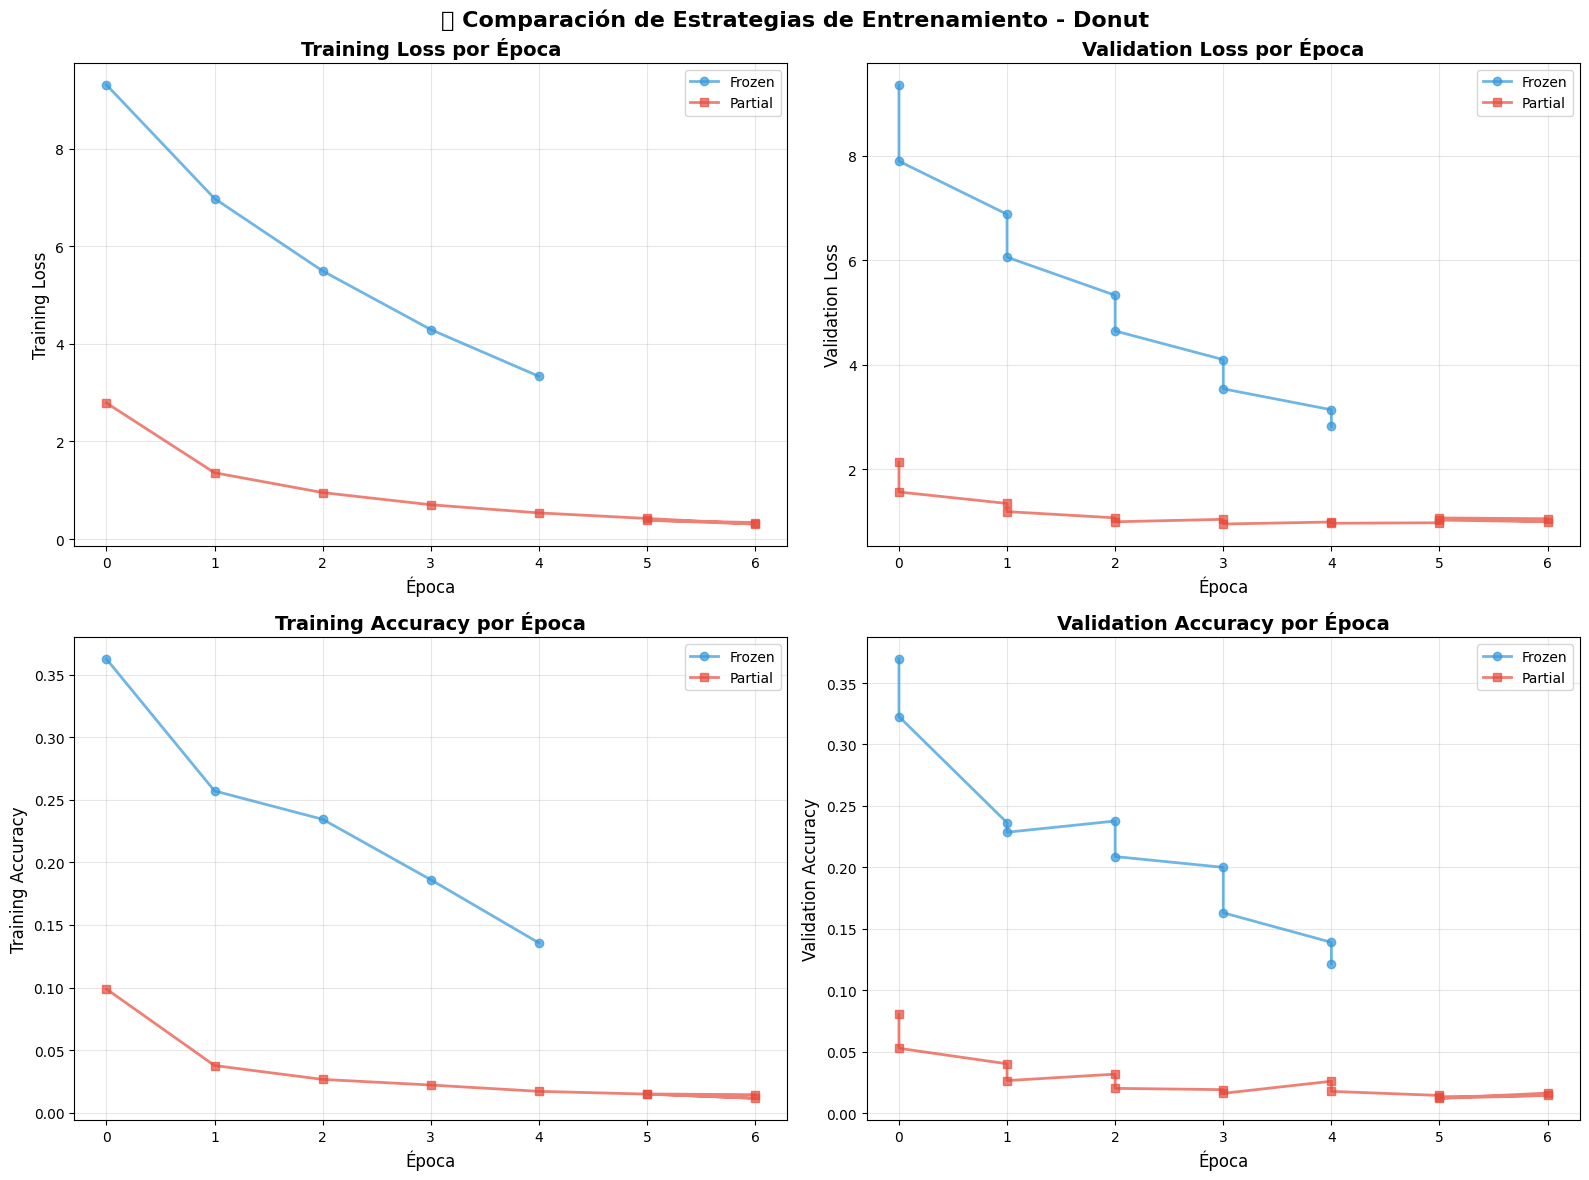


✅ Gráficas generadas exitosamente


In [5]:
# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📊 Comparación de Estrategias de Entrenamiento - Donut', fontsize=16, fontweight='bold')

colors = {'frozen': '#3498db', 'partial': '#e74c3c', 'full': '#2ecc71'}
markers = {'frozen': 'o', 'partial': 's', 'full': '^'}

# 1. Training Loss
ax = axes[0, 0]
for strategy, df in metrics_data.items():
    epoch_data = df[df['train_loss_epoch'].notna()]
    if len(epoch_data) > 0:
        ax.plot(epoch_data['epoch'], epoch_data['train_loss_epoch'], 
               label=strategy.capitalize(), color=colors[strategy], 
               marker=markers[strategy], linewidth=2, markersize=6, alpha=0.7)
ax.set_xlabel('Época', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)
ax.set_title('Training Loss por Época', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Validation Loss
ax = axes[0, 1]
for strategy, df in metrics_data.items():
    epoch_data = df[df['val_loss'].notna()]
    if len(epoch_data) > 0:
        ax.plot(epoch_data['epoch'], epoch_data['val_loss'], 
               label=strategy.capitalize(), color=colors[strategy], 
               marker=markers[strategy], linewidth=2, markersize=6, alpha=0.7)
ax.set_xlabel('Época', fontsize=12)
ax.set_ylabel('Validation Loss', fontsize=12)
ax.set_title('Validation Loss por Época', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Training Accuracy
ax = axes[1, 0]
for strategy, df in metrics_data.items():
    epoch_data = df[df['train_acc'].notna()]
    if len(epoch_data) > 0:
        ax.plot(epoch_data['epoch'], epoch_data['train_acc'], 
               label=strategy.capitalize(), color=colors[strategy], 
               marker=markers[strategy], linewidth=2, markersize=6, alpha=0.7)
ax.set_xlabel('Época', fontsize=12)
ax.set_ylabel('Training Accuracy', fontsize=12)
ax.set_title('Training Accuracy por Época', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Validation Accuracy
ax = axes[1, 1]
for strategy, df in metrics_data.items():
    epoch_data = df[df['val_acc'].notna()]
    if len(epoch_data) > 0:
        ax.plot(epoch_data['epoch'], epoch_data['val_acc'], 
               label=strategy.capitalize(), color=colors[strategy], 
               marker=markers[strategy], linewidth=2, markersize=6, alpha=0.7)
ax.set_xlabel('Época', fontsize=12)
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.set_title('Validation Accuracy por Época', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Gráficas generadas exitosamente")

In [6]:
# Tabla comparativa final
print("\n" + "="*80)
print("🏆 TABLA COMPARATIVA FINAL")
print("="*80)

comparison_data = []

for strategy, df in metrics_data.items():
    epoch_data = df[df['epoch'].notna()]
    
    if len(epoch_data) > 0:
        row = {
            'Estrategia': strategy.capitalize(),
            'Épocas': len(epoch_data),
            'Mejor Val Loss': epoch_data['val_loss'].min() if 'val_loss' in epoch_data.columns else None,
            'Mejor Val Acc': epoch_data['val_acc'].max() if 'val_acc' in epoch_data.columns else None,
            'Final Train Loss': epoch_data.iloc[-1]['train_loss_epoch'] if 'train_loss_epoch' in epoch_data.columns else None,
            'Final Val Loss': epoch_data.iloc[-1]['val_loss'] if 'val_loss' in epoch_data.columns else None
        }
        comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

# Formatear números
for col in ['Mejor Val Loss', 'Mejor Val Acc', 'Final Train Loss', 'Final Val Loss']:
    if col in comparison_df.columns:
        comparison_df[col] = comparison_df[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")

print(comparison_df.to_string(index=False))
print("="*80)


🏆 TABLA COMPARATIVA FINAL
Estrategia  Épocas Mejor Val Loss Mejor Val Acc Final Train Loss Final Val Loss
    Frozen      28         2.8175        0.3695              N/A            N/A
   Partial     324         0.9490        0.0806           0.3391            N/A
